## ECE 498 DS - Mini-Project 2:  MiMoSA 
##### MiMoSA (Mixture Model-based Single-cell Analysis) is a workflow to cluster single-cells using RPKM measure output by the MapRSeq pipeline developed at Mayo Clinic.

### Originally developed by Arjun Athreya (athreya2@illinois.edu) in R 
### Research Paper available at http://ieeexplore.ieee.org/abstract/document/7822581/

#### ECE 498 DS Staff (Saurabh Jha and Lavin Devnani adapted the code for Python and Jupyter Notebook)


# Import Packages for Working With the Datasets
* pandas - to load datasets
* numpy - vector manipulation
* matplotlib - plotting/visualization
* sklean - scikit learning package containg ML algorithm implementations
* seaborn - plotthing/visualization

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from scipy import stats

import seaborn as sns
# %matplotlib notebook
sns.set_style('whitegrid')
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Biology Primer

## What is a gene?
A gene is a sequence of DNA or RNA which codes for a molecule that has a function.

https://en.wikipedia.org/wiki/Gene

https://www.youtube.com/watch?v=ONGdehkB8jU

## What is a cell?
The cell  is the basic structural, functional, and biological unit of all known living organisms. A cell is the smallest unit of life that can replicate independently, and cells are often called the "building blocks of life". 

https://en.wikipedia.org/wiki/Cell_(biology)

## What is a gene expression?
Gene expression is the activity level of a gene.

https://en.wikipedia.org/wiki/Gene_expression

## What is RPKM?
**RPKM** is reads per kilobase per million mapped reads, which is how many reads (short sequences from a sequencing machine) map to a region of a gene. So at large without loosing generality, better the RPKM better the quality of the gene expression data. 

### You may skip the details about RPKM below
The expression value for each gene was normalized by accounting for the sequencing depth (number of short DNA sequence strings from the sequencing platform aligned to a gene) and length of the gene. The measure of gene expression is Reads Per Kilo Million (RPKM). The range of the RPKM is between 0 and 2, 000.

**Formula**

RPKM =   numReads / ( geneLength/1000 * totalNumReads/1,000,000 )

numReads - number of reads mapped to a gene sequence

geneLength - length of the gene sequence

totalNumReads - total number of mapped reads of a sample


# Import your dataset into the pandas dataframe
### Recall that our experiment consists of two different datasets
   1. Baseline: Cells are not treated with metformin
   2. Metformin: Cells are treated with metformin
   

In [2]:
baseline_csv = pd.read_csv("498DS_BaselineData.csv")
metformin_csv = pd.read_csv("498DS_MetforminData.csv")

# Exploring Pandas Dataframe
## You would want to run the following commands associated with pandas to explore the pandas dataframes
 1. head - helps to visualize first few rows and first few columns, e.g. usage 
   ```python 
   baseline_csv.head()
   ```
 2. len - returns number of rows or columns in the dataset based on the usage, e.g. usage
   ```python
   # return number of rows
   len(baseline_csv)
   # returns number of columns
   len(baseline_csv.columns)
   ```
 3. list - returns list of all columns, e.g. usage
    ```python 
    list(baselines_csv)
    ```
 4. columns - returns columns of the dataframe. This command does not print all columns depending on notebook settings., e.g. usage
    ```python
    baseline_csv.columns
    ```

In [3]:
baseline_csv.head()

,Chr,GeneID,StartCoding,Stop,CodingLength,s_62_M2_N701_S502_RPKM,s_62_M2_N701_S503_RPKM,s_62_M2_N701_S504_RPKM,s_62_M2_N701_S505_RPKM,s_62_M2_N701_S506_RPKM,...,s_85_M2_N711_S501_RPKM,s_85_M2_N711_S502_RPKM,s_85_M2_N711_S503_RPKM,s_85_M2_N711_S504_RPKM,s_85_M2_N711_S506_RPKM,s_85_M2_N711_S507_RPKM,s_85_M2_N711_S508_RPKM,s_85_M2_N712_S503_RPKM,s_85_M2_N712_S504_RPKM,s_85_M2_N712_S505_RPKM
0,chr1,AKR1A1,46016455,46035723,1580,0.000000,0.000000,14.531662,14.268424,26.459120,...,0.000000,0.0,1.037722,24.391142,17.188837,0.000000,2.173159,48.894683,9.213393,0.000000
1,chr1,ANP32E,150190717,150208504,3553,263.583489,0.000000,871.851991,439.864123,575.552858,...,526.275026,0.0,454.455263,587.120601,469.683190,565.316349,343.552412,236.214451,838.993154,141.792692
2,chr1,ARF1,228270361,228286913,2198,41.926167,486.847569,110.116896,156.263029,51.559562,...,148.414035,0.0,36.850006,106.643195,78.107210,40.569316,104.663612,92.728846,80.468384,32.867866
3,chr1,ARPC5,183595332,183604985,1982,63.349868,0.000000,139.493933,170.281826,184.750299,...,30.830665,0.0,184.144951,65.880840,60.437829,70.357630,150.501134,94.707269,144.506633,58.816776
4,chr1,ATP5F1,111991743,112004525,2101,327.593082,0.000000,221.522538,311.490830,207.609025,...,221.936539,0.0,175.275819,141.346657,177.968802,189.485482,113.785720,198.088156,76.215503,37.511264


In [4]:
metformin_csv.head()

,Chr,GeneID,Start,Stop,CodingLength,s_63_M2_N701_S501_RPKM,s_63_M2_N701_S502_RPKM,s_63_M2_N701_S503_RPKM,s_63_M2_N701_S504_RPKM,s_63_M2_N701_S505_RPKM,...,s_204_M2_N712_S501_RPKM,s_204_M2_N712_S502_RPKM,s_204_M2_N712_S503_RPKM,s_204_M2_N712_S504_RPKM,s_204_M2_N712_S505_RPKM,s_204_M2_N712_S506_RPKM,s_204_M2_N712_S507_RPKM,s_204_M2_N712_S508_RPKM,s_lane1_Undetermined_RPKM.1,s_lane2_Undetermined_RPKM.1
0,chr1,ANKRD36BP1,168214819,168216668,1850,0.440043,0.000000,12.693285,27.412660,7.378925,...,0.141431,4.867474,0.000000,2.293990,0.000000,2.508867,1.699676,10.164217,6.560453,4.703404
1,chr1,ANP32E,150190717,150208504,3553,517.592029,10.749289,754.147392,534.208422,356.355539,...,1533.653888,586.403579,571.360726,1441.236773,793.018158,439.711955,504.272351,634.004705,622.270556,633.534112
2,chr1,APOA1BP,156561558,156564091,1121,79.882864,0.608389,1.102520,5.517006,6.088765,...,44.580451,65.266924,0.000000,9.043854,13.633060,0.414041,38.147951,96.536841,47.216858,48.830575
3,chr1,ARF1,228270361,228286913,2198,231.482884,70.434447,73.379540,139.279295,166.755975,...,319.976644,99.860175,0.000000,86.242051,50.008005,134.934356,19.741917,156.957326,148.013958,152.447260
4,chr1,ARPC5,183595332,183604985,1982,162.240771,59.185012,164.311943,123.878491,244.505991,...,205.146479,135.163275,0.000000,135.491107,155.697364,77.512851,121.841571,151.602966,132.166204,136.973007


In [5]:
print("Number of rows %d" % len(baseline_csv))
print("Number of columns %d" % len(baseline_csv.columns))

Number of rows 1170
Number of columns 174


In [6]:
list(baseline_csv)

['Chr',
 'GeneID',
 'StartCoding',
 'Stop',
 'CodingLength',
 's_62_M2_N701_S502_RPKM',
 's_62_M2_N701_S503_RPKM',
 's_62_M2_N701_S504_RPKM',
 's_62_M2_N701_S505_RPKM',
 's_62_M2_N701_S506_RPKM',
 's_62_M2_N701_S507_RPKM',
 's_62_M2_N701_S508_RPKM',
 's_62_M2_N702_S501_RPKM',
 's_62_M2_N702_S502_RPKM',
 's_62_M2_N702_S503_RPKM',
 's_62_M2_N702_S504_RPKM',
 's_62_M2_N702_S505_RPKM',
 's_62_M2_N702_S506_RPKM',
 's_62_M2_N702_S507_RPKM',
 's_62_M2_N702_S508_RPKM',
 's_62_M2_N703_S501_RPKM',
 's_62_M2_N703_S502_RPKM',
 's_62_M2_N703_S504_RPKM',
 's_62_M2_N703_S505_RPKM',
 's_62_M2_N703_S506_RPKM',
 's_62_M2_N703_S507_RPKM',
 's_62_M2_N703_S508_RPKM',
 's_62_M2_N704_S501_RPKM',
 's_62_M2_N704_S502_RPKM',
 's_62_M2_N704_S503_RPKM',
 's_62_M2_N704_S504_RPKM',
 's_62_M2_N704_S505_RPKM',
 's_62_M2_N704_S506_RPKM',
 's_62_M2_N704_S507_RPKM',
 's_62_M2_N704_S508_RPKM',
 's_62_M2_N705_S501_RPKM',
 's_62_M2_N705_S502_RPKM',
 's_62_M2_N705_S504_RPKM',
 's_62_M2_N705_S505_RPKM',
 's_62_M2_N705_S506_R

In [7]:
list(metformin_csv)

['Chr',
 'GeneID',
 'Start',
 'Stop',
 'CodingLength',
 's_63_M2_N701_S501_RPKM',
 's_63_M2_N701_S502_RPKM',
 's_63_M2_N701_S503_RPKM',
 's_63_M2_N701_S504_RPKM',
 's_63_M2_N701_S505_RPKM',
 's_63_M2_N701_S507_RPKM',
 's_63_M2_N701_S508_RPKM',
 's_63_M2_N702_S501_RPKM',
 's_63_M2_N702_S502_RPKM',
 's_63_M2_N702_S504_RPKM',
 's_63_M2_N702_S505_RPKM',
 's_63_M2_N702_S506_RPKM',
 's_63_M2_N702_S507_RPKM',
 's_63_M2_N702_S508_RPKM',
 's_63_M2_N703_S502_RPKM',
 's_63_M2_N703_S504_RPKM',
 's_63_M2_N703_S505_RPKM',
 's_63_M2_N703_S506_RPKM',
 's_63_M2_N703_S507_RPKM',
 's_63_M2_N703_S508_RPKM',
 's_63_M2_N704_S501_RPKM',
 's_63_M2_N704_S502_RPKM',
 's_63_M2_N704_S504_RPKM',
 's_63_M2_N704_S505_RPKM',
 's_63_M2_N704_S506_RPKM',
 's_63_M2_N704_S507_RPKM',
 's_63_M2_N704_S508_RPKM',
 's_63_M2_N705_S502_RPKM',
 's_63_M2_N705_S504_RPKM',
 's_63_M2_N705_S505_RPKM',
 's_63_M2_N705_S506_RPKM',
 's_63_M2_N705_S507_RPKM',
 's_63_M2_N705_S508_RPKM',
 's_63_M2_N706_S501_RPKM',
 's_63_M2_N706_S502_RPKM',


In [8]:
baseline_csv.columns

Index(['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength',
       's_62_M2_N701_S502_RPKM', 's_62_M2_N701_S503_RPKM',
       's_62_M2_N701_S504_RPKM', 's_62_M2_N701_S505_RPKM',
       's_62_M2_N701_S506_RPKM',
       ...
       's_85_M2_N711_S501_RPKM', 's_85_M2_N711_S502_RPKM',
       's_85_M2_N711_S503_RPKM', 's_85_M2_N711_S504_RPKM',
       's_85_M2_N711_S506_RPKM', 's_85_M2_N711_S507_RPKM',
       's_85_M2_N711_S508_RPKM', 's_85_M2_N712_S503_RPKM',
       's_85_M2_N712_S504_RPKM', 's_85_M2_N712_S505_RPKM'],
      dtype='object', length=174)

In [9]:
baseline_csv['GeneID'].tolist()

['AKR1A1',
 'ANP32E',
 'ARF1',
 'ARPC5',
 'ATP5F1',
 'ATP6V0B',
 'ATPIF1',
 'C1orf122',
 'C1orf123',
 'C1orf133',
 'C1orf159',
 'C1orf31',
 'C1orf35',
 'C4BPB',
 'CACYBP',
 'CAPZA1',
 'CCT3',
 'CDC20',
 'CDC42',
 'CDCA8',
 'CKS1B',
 'CNIH4',
 'CNN3',
 'CTPS',
 'CYR61',
 'DDAH1',
 'DDOST',
 'DNAJC8',
 'DNTTIP2',
 'EFHD2',
 'EIF3I',
 'ENO1',
 'F3',
 'FBXO6',
 'G0S2',
 'GAS5',
 'GNG5',
 'GNPAT',
 'HBXIP',
 'HMGN2',
 'HNRNPR',
 'HSPB11',
 'ILF2',
 'ISG15',
 'JTB',
 'KDM1A',
 'KIF2C',
 'KRTCAP2',
 'LSM10',
 'MFSD2A',
 'MGST3',
 'MINOS1',
 'MRPL37',
 'MRPL55',
 'MRPS15',
 'MRPS21',
 'NDUFS5',
 'NME7',
 'NOC2L',
 'PARK7',
 'PFDN2',
 'PPOX',
 'PRDX1',
 'PRDX6',
 'PSMB4',
 'PSMD4',
 'RASAL2',
 'RHOC',
 'RPA2',
 'RPF1',
 'RPL11',
 'RPL5',
 'RPS27',
 'RPS8',
 'S100A10',
 'S100A11',
 'S100A16',
 'S100A4',
 'S100A6',
 'SCAMP3',
 'SDHB',
 'SEC22B',
 'SEP15',
 'SF3A3',
 'SH3BGRL3',
 'SLC39A1',
 'SLC50A1',
 'SNHG3',
 'SNORA61',
 'SNORD47',
 'SNORD80',
 'SNORD99',
 'SNRPE',
 'SRP9',
 'SSR2',
 'STMN1',


In [10]:
metformin_csv['GeneID'].tolist()

['ANKRD36BP1',
 'ANP32E',
 'APOA1BP',
 'ARF1',
 'ARPC5',
 'ATP5F1',
 'ATP6V0B',
 'BCAS2',
 'C1orf123',
 'C1orf31',
 'C1orf54',
 'CACYBP',
 'CAP1',
 'CAPZA1',
 'CCT3',
 'CDA',
 'CDC20',
 'CDC42',
 'CDCA8',
 'CENPF',
 'CKS1B',
 'CNIH4',
 'CNN3',
 'COL8A2',
 'CTPS',
 'CYR61',
 'DAP3',
 'DDAH1',
 'DDOST',
 'DNAJC8',
 'DNTTIP2',
 'DPM3',
 'EBNA1BP2',
 'EFHD2',
 'EIF2D',
 'EIF3I',
 'ENO1',
 'F3',
 'FDPS',
 'G0S2',
 'GAS5',
 'GGPS1',
 'GNG5',
 'GSTM3',
 'GTF2B',
 'HBXIP',
 'HMGN2',
 'HSPB11',
 'ILF2',
 'KDM1A',
 'KRTCAP2',
 'LAMTOR2',
 'LZIC',
 'MED18',
 'METTL18',
 'MFSD2A',
 'MGST3',
 'MINOS1',
 'MRPL55',
 'MRPS14',
 'NDUFS2',
 'NDUFS5',
 'NME7',
 'NOC2L',
 'NUF2',
 'PARK7',
 'PFDN2',
 'PINK1',
 'PPT1',
 'PRDX1',
 'PRDX6',
 'PRPF38A',
 'PSMB4',
 'PSMD4',
 'RABGGTB',
 'RHOC',
 'RPA2',
 'RPL11',
 'RPL5',
 'RPS27',
 'RPS8',
 'S100A10',
 'S100A11',
 'S100A16',
 'S100A4',
 'S100A6',
 'SCAMP3',
 'SDHB',
 'SEC22B',
 'SEP15',
 'SF3A3',
 'SH3BGRL3',
 'SMYD3',
 'SNHG12',
 'SNHG3',
 'SNORA61',
 'SNORA

# Notes
1. There are only 1170 rows and 174 columns
2. Not all columns are important for data analysis/clustering. E.g., Chr, GeneID, StartCoding, Stop, CodingLength are description about the feature and has relevance to biology
3. These datasets are already downsized from 23,398 genes to 1170 genes and 192 cells to 169 cells. Only 20% of the 23, 398 genes show expression levels greater than 32 on the RPKM scale, which is a heuristic that can be used to decide whether a gene is expressed or not as recommended by MAP-Rseq[1]. Roughly 10% of the baseline and metformin-treated cells had low sequencing coverage (< 1M reads per cell), so we excluded those cells from our analysis.

#### References
1. K. R. Kalari, A. A. Nair, J. D. Bhavsar, D. R. OBrien, J. I. Davila, M. A. Bockol, J. Nie, X. Tang, S. Baheti, J. B. Doughty et al., “Map- rseq: mayo analysis pipeline for rna sequencing,” BMC bioinformat- ics, vol. 15, no. 1, p. 1, 2014

# Visualizing datasets
## Plot 1 - Variation of gene expression across different genes for selected cells

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


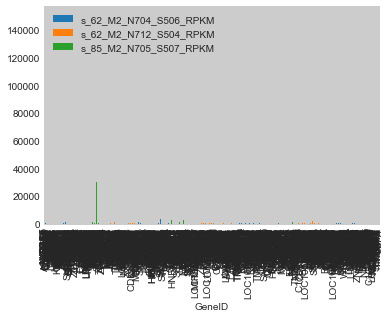

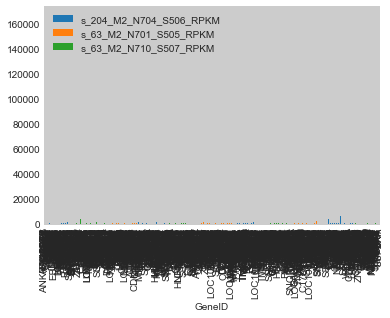

In [11]:
#'Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength', 
#'Chr', 'GeneID', 'Start', 'Stop', 'CodingLength', 
base1 = baseline_csv[['Chr', 'GeneID', 's_62_M2_N704_S506_RPKM','s_62_M2_N712_S504_RPKM', 's_85_M2_N705_S507_RPKM']]
met1 = metformin_csv[['Chr', 'GeneID','s_204_M2_N704_S506_RPKM', 's_63_M2_N701_S505_RPKM', 's_63_M2_N710_S507_RPKM']]
base1.plot(x='GeneID', y=['s_62_M2_N704_S506_RPKM','s_62_M2_N712_S504_RPKM', 's_85_M2_N705_S507_RPKM'], kind='bar')
met1.plot(x='GeneID', y=['s_204_M2_N704_S506_RPKM', 's_63_M2_N701_S505_RPKM', 's_63_M2_N710_S507_RPKM'], kind='bar')
plt.show()


## Plot 2 - Variation of gene expression across the cells for a given gene **ARPC5** or **CDC42**

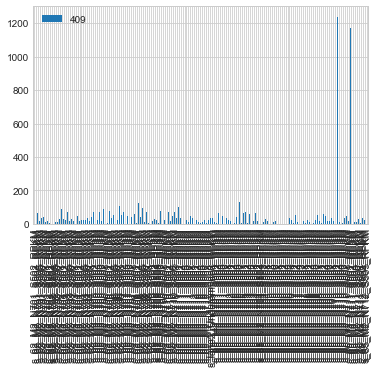

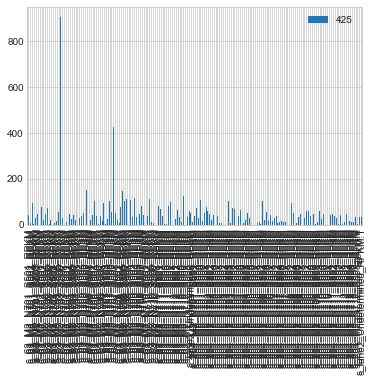

In [12]:
base = baseline_csv[baseline_csv['GeneID'] == 'SERPINB1']
met = metformin_csv[metformin_csv['GeneID'] == 'SERPINB1']

base2 = base.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
met2 = met.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])

base2 = base2.transpose()
met2 = met2.transpose()

base2.plot(kind = 'bar')
met2.plot(kind = 'bar')
plt.show()

# Comparing the distributions

In [13]:
baselineT = baseline_csv.transpose()
metforminT = metformin_csv.transpose()
geneNames = set(baseline_csv['GeneID'].tolist()).intersection(set(metformin_csv['GeneID'].tolist()))
print("%d genes common in both dataset" % len(geneNames))
numDifferentlyExpressedGene = 0
candidateGenes = set()
count10 = 0
count05 = 0
count025 = 0
count01 = 0
count005 = 0
count001 = 0
for selectGene in geneNames:
    bIndx = baselineT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    mIndx = metforminT[1:2:].transpose()['GeneID'].tolist().index(selectGene)
    b = np.log(baselineT[bIndx].iloc[6:169].astype(float))
    m = np.log(metforminT[mIndx].iloc[6:169].astype(float))
    Vars = {
        "Baseline": b,
        "Metformin": m
    }
    testResult = stats.ks_2samp(Vars['Baseline'], Vars["Metformin"])
    if testResult[1] < .1:
        count10+=1
        if testResult[1] < .05:
            count05+=1
            if testResult[1] < .025:
                count025+=1
                if testResult[1] < .01:
                    count01+=1
                    if testResult[1] < .005:
                        count005+=1
                        if testResult[1] < .001:
                            count001+=1
    if testResult[1] < 1e-1:
        candidateGenes.add(selectGene)
        numDifferentlyExpressedGene += 1
        print("%d: %s gene is differently expressed in baseline and metformin treated cells" % (numDifferentlyExpressedGene, selectGene))
        print("Test Statistics %f, %g" % (testResult[0], testResult[1]))

833 genes common in both dataset
1: ATP5F1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
2: VMP1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.239264, 0.000134573
3: RPS7 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
4: ATP6V0E1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
5: RPL27 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.220859, 0.000557352
6: TMSB10 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
7: GSTO1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.282209, 3.13969e-06
8: COPB1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.159509, 0.0279753
9: RPS27L gene is differently expresse

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


42: HNRNPA2B1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
43: CDK1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
44: ANXA3 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.177914, 0.00986699
45: ATP5O gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
46: CDC45 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
47: IMPDH2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
48: SET gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
49: CCDC56 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
50: OST4 gene is differently expressed in baseline and metformin tre

120: RPA2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
121: SERPINB1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.220859, 0.000557352
122: S100A4 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.147239, 0.0526098
123: SSR2 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
124: SAA1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
125: MRPL47 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.184049, 0.0067975
126: RPL37 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.233129, 0.000218861
127: APEX1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
128: RPS4X gene is differently expressed in baseline and me

213: NME7 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
214: RPL10 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.165644, 0.020017
215: COX4I1 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.141104, 0.0707905
216: VAMP8 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.202454, 0.00206028
217: GPI gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.134969, 0.0940553
218: PYCARD gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.171779, 0.0141428
219: UCHL3 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.153374, 0.0386069
220: TMBIM4 gene is differently expressed in baseline and metformin treated cells
Test Statistics 0.196319, 0.00310613
221: PRDX3 gene is differently expressed in baseline and metfo

In [14]:
d = {'Alpha': [.1, .05, .025, .01, .005, .001], 'Different Genes Count': [count10, count05, count025, count01, count005, count001]}
df = pd.DataFrame(data=d)
df.head()

,Alpha,Different Genes Count
0,0.100,309
1,0.050,222
2,0.025,173
3,0.010,138
4,0.005,109


In [15]:
#Task2
rpkmThreshold = 32
numBaselineClustGMM = 2
numMetforminClustGMM = 3

baseRPKM = baseline_csv.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
metRPKM = metformin_csv.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])
baseRPKM = baseRPKM.transpose()
metRPKM = metRPKM.transpose()

baseGMM = GaussianMixture(n_components=numBaselineClustGMM, random_state=0).fit(baseRPKM)
baseGMM_pred = baseGMM.predict(baseRPKM)
baseCenters = baseGMM.means_
print(np.bincount(baseGMM_pred))

metGMM = GaussianMixture(n_components=numMetforminClustGMM, random_state=0).fit(metRPKM)
metGMM_pred = metGMM.predict(metRPKM)
metCenters = metGMM.means_
print(np.bincount(metGMM_pred))

print("Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene")
print("There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine")
print("There are 161 Cells in Cluster 0, 11 Cells in Cluster 1, and 5 Cells in Cluster 2 for Metformin")

[152  17]
[161  11   5]
Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene
There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine
There are 161 Cells in Cluster 0, 11 Cells in Cluster 1, and 5 Cells in Cluster 2 for Metformin


In [16]:
baseline_means = baseline_csv.iloc[:, 0:5]
baseline_means["1"] = baseCenters[0]
baseline_means["2"] = baseCenters[1]

metformin_means = metformin_csv.iloc[:, 0:5]
metformin_means["1"] = metCenters[0]
metformin_means["2"] = metCenters[1]
metformin_means["3"] = metCenters[2]
baseline_means.head()


,Chr,GeneID,StartCoding,Stop,CodingLength,1,2
0,chr1,AKR1A1,46016455,46035723,1580,23.878180,59.520515
1,chr1,ANP32E,150190717,150208504,3553,551.845311,314.138091
2,chr1,ARF1,228270361,228286913,2198,113.391566,76.383464
3,chr1,ARPC5,183595332,183604985,1982,106.269814,51.795593
4,chr1,ATP5F1,111991743,112004525,2101,214.599276,71.062689


In [17]:
print(np.unique(baseGMM_pred, return_counts=True))
print(np.unique(metGMM_pred, return_counts=True))

print("Bu should be cluster 2 because it has 17 cells in it")
print("Bv should be cluster 1 because it has 152 cells in it")

print("Mx should be cluster 3 because it has 5 cells in it")
print("My should be cluster 2 because it has 11 cells in it")
print("Mz should be cluster 1 because it has 161 cells in it")

metformin_upMy_downMx_upMz_DF = metformin_means
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['3'] < rpkmThreshold]
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['2'] > rpkmThreshold]
metformin_upMy_downMx_upMz_DF = metformin_upMy_downMx_upMz_DF[metformin_upMy_downMx_upMz_DF['1'] > rpkmThreshold]

baseline_upBv_downBu_DF = baseline_means
baseline_upBv_downBu_DF = baseline_upBv_downBu_DF[baseline_upBv_downBu_DF['2'] < rpkmThreshold]
baseline_upBv_downBu_DF = baseline_upBv_downBu_DF[baseline_upBv_downBu_DF['1'] > rpkmThreshold]

(array([0, 1]), array([152,  17]))
(array([0, 1, 2]), array([161,  11,   5]))
Bu should be cluster 2 because it has 17 cells in it
Bv should be cluster 1 because it has 152 cells in it
Mx should be cluster 3 because it has 5 cells in it
My should be cluster 2 because it has 11 cells in it
Mz should be cluster 1 because it has 161 cells in it


In [18]:
geneList = metformin_upMy_downMx_upMz_DF['GeneID'].tolist()
newlyDownregulatedGenes_inMx_fromBu_df = metformin_upMy_downMx_upMz_DF
for x in baseline_upBv_downBu_DF['GeneID']:
    if x in geneList:
        newlyDownregulatedGenes_inMx_fromBu_df = newlyDownregulatedGenes_inMx_fromBu_df[newlyDownregulatedGenes_inMx_fromBu_df['GeneID'] != x]

geneList = newlyDownregulatedGenes_inMx_fromBu_df['GeneID'].tolist()
for x in baseline_means['GeneID']:
    if x not in geneList:
        print(x)
        baseline_means = baseline_means[baseline_means['GeneID'] != x]
        metformin_means = metformin_means[metformin_means['GeneID'] != x]

geneList = baseline_means['GeneID'].tolist()
for x in metformin_means['GeneID'].tolist():
    if x not in geneList:
        metformin_means = metformin_means[metformin_means['GeneID'] != x]
        
baseline_means = baseline_means.reset_index(drop=True)
metformin_means = metformin_means.reset_index(drop=True)
dat = {'Bu': baseline_means['2'], 'Bv': baseline_means['1'], 'My': metformin_means['2'], 'Mz': metformin_means['1']}
new_df = pd.DataFrame(data=dat)
new_df = np.log(new_df + 1)

new_df['Mean'] = new_df.apply(np.mean, axis=1)
new_df['STD'] = new_df.apply(np.std, axis=1)
new_df['Mx'] = metformin_means['3']
new_df['Mx'] = np.log(new_df['Mx'] + 1)
new_df.head()

AKR1A1
ANP32E
ARF1
ATPIF1
C1orf122
C1orf123
C1orf133
C1orf159
C1orf35
C4BPB
CACYBP
CAPZA1
CCT3
CDC42
CDCA8
CKS1B
CNN3
CTPS
CYR61
DDAH1
DDOST
DNAJC8
EFHD2
EIF3I
ENO1
F3
FBXO6
G0S2
GNG5
GNPAT
HBXIP
HMGN2
HNRNPR
ILF2
ISG15
JTB
KDM1A
KIF2C
KRTCAP2
LSM10
MFSD2A
MGST3
MINOS1
MRPL37
MRPL55
MRPS15
MRPS21
NDUFS5
NOC2L
PFDN2
PPOX
PRDX1
PRDX6
PSMB4
PSMD4
RASAL2
RPF1
RPL5
RPS27
RPS8
S100A10
S100A11
S100A16
S100A4
S100A6
SCAMP3
SEC22B
SEP15
SF3A3
SH3BGRL3
SLC39A1
SLC50A1
SNHG3
SNORA61
SNORD47
SNORD80
SNORD99
SNRPE
SRP9
STMN1
SYF2
THRAP3
TIMM17A
TOE1
TRAPPC3
UAP1
UFC1
UQCRH
VPS72
XKR8
ACP1
ACTR3
ADI1
ANXA4
ARPC2
AUP1
BARD1
BUB1
BZW1
C2orf28
C2orf49
C2orf74
CALM2
CCT7
CENPA
COX5B
COX7A2L
CRIM1
DBI
DDX1
DNAJC10
DUSP11
EIF4E2
EIF5B
FEZ2
GEMIN6
GMPPA
GPN1
GPR1
GTF3C2
HSPD1
HSPE1
LAPTM4A
LINC00471
MDH1
METTL5
MIR3682
MKI67IP
MMADHC
MOB1A
MRPL53
MRPS5
MYEOV2
NAGK
NDUFB3
NFE2L2
NFU1
NIF3L1
NOP58
OBFC2A
PCBP1
PDIA6
PPIL3
PPP1CB
PSMD14
PTMA
RNF181
RPL31
RPL37A
RPS27A
RPS7
SLC20A1
SNRPG
SUMO1
TMSB10
TPRKB
TRM

,Bu,Bv,My,Mz,Mean,STD,Mx
0,3.966428,4.675347,5.258095,4.896712,4.699145,0.421639,0.0
1,4.277536,5.373421,3.963450,5.336792,4.737800,0.561118,0.0
2,5.294395,5.100574,3.604205,4.868313,4.716872,0.590207,0.0
3,3.910229,4.499485,4.939882,4.543935,4.473383,0.328762,0.0
4,5.081032,4.551463,6.026550,4.457334,5.029095,0.557253,0.0


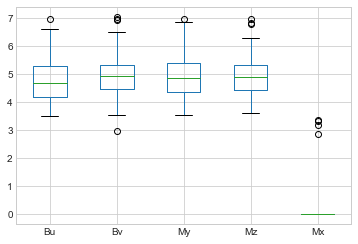

In [19]:
new_df.boxplot(column=['Bu', 'Bv', 'My', 'Mz', 'Mx'])
plt.show()

In [20]:
#K-means Clustering
rpkmThreshold = 32
numBaselineClustGMM = 2
numMetforminClustGMM = 3

baseKRPKM = baseline_csv.drop(columns=['Chr', 'GeneID', 'StartCoding', 'Stop', 'CodingLength'])
metKRPKM = metformin_csv.drop(columns=['Chr', 'GeneID', 'Start', 'Stop', 'CodingLength'])
baseKRPKM = baseKRPKM.transpose()
metKRPKM = metKRPKM.transpose()

def do_kmeans(matrix, num_clusters):
    cluster = KMeans(n_clusters=num_clusters, random_state=0).fit(matrix)
    kmeans_pred = cluster.predict(matrix)
    return silhouette_score(matrix, kmeans_pred)

print("Silhouette Analysis for BaseRPKM\n")
N = [i for i in range (2, len(baseKRPKM))]
scores = [do_kmeans(baseKRPKM, i) for i in N]
recommended_BaselineN = scores.index(max(scores)) + 2
for i in range(0, len(N)):
    print("For n={}, score={:.3f}".format(N[i], scores[i]))
    

print("Silhouette Analysis for MetRPKM\n")
N = [i for i in range (2, len(metKRPKM))]
scores = [do_kmeans(metKRPKM, i) for i in N]
recommended_MetforminN = scores.index(max(scores)) + 2
for i in range(0, len(N)):
    print("For n={}, score={:.3f}".format(N[i], scores[i]))

Silhouette Analysis for BaseRPKM

For n=2, score=0.919
For n=3, score=0.879
For n=4, score=0.873
For n=5, score=0.839
For n=6, score=0.840
For n=7, score=0.827
For n=8, score=0.829
For n=9, score=0.225
For n=10, score=0.841
For n=11, score=0.825
For n=12, score=0.235
For n=13, score=0.199
For n=14, score=0.210
For n=15, score=0.202
For n=16, score=0.200
For n=17, score=0.201
For n=18, score=0.210
For n=19, score=0.209
For n=20, score=0.199
For n=21, score=0.201
For n=22, score=0.193
For n=23, score=0.178
For n=24, score=0.166
For n=25, score=0.108
For n=26, score=0.095
For n=27, score=0.075
For n=28, score=0.073
For n=29, score=0.069
For n=30, score=0.078
For n=31, score=0.100
For n=32, score=0.070
For n=33, score=0.080
For n=34, score=0.074
For n=35, score=0.081
For n=36, score=0.079
For n=37, score=0.076
For n=38, score=0.071
For n=39, score=0.072
For n=40, score=0.061
For n=41, score=0.071
For n=42, score=0.078
For n=43, score=0.064
For n=44, score=0.052
For n=45, score=0.064
For n=

In [21]:
baseKM = KMeans(n_clusters=recommended_BaselineN, random_state=0).fit(baseKRPKM)
baseKM_pred = baseKM.predict(baseKRPKM)
baseKCenters = baseKM.cluster_centers_
print(len(baseKM_pred))
print(np.bincount(baseKM_pred))
metKM = KMeans(n_clusters=recommended_MetforminN, random_state=0).fit(metKRPKM)
metKM_pred = metKM.predict(metKRPKM)
metKCenters = metKM.cluster_centers_
print(np.bincount(metKM_pred))
#print(metKCenters)
print("Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene")
print("There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine")
print("There are 161 Cells in Cluster 0 and 16 Cells in Cluster 1 for Metformin")

169
[152  17]
[161  16]
Each of the means represent the average level of gene expression in all of the cells in the cluster for each Gene
There are 152 Cells in Cluster 0 and 17 cells in Cluster 1 for BaseLine
There are 161 Cells in Cluster 0, 11 Cells in Cluster 1, and 5 Cells in Cluster 2 for Metformin


In [23]:
baseline_Kmeans = baseline_csv.iloc[:, 0:5]
baseline_Kmeans["1"] = baseKCenters[0]
baseline_Kmeans["2"] = baseKCenters[1]

metformin_Kmeans = metformin_csv.iloc[:, 0:5]
metformin_Kmeans["1"] = metKCenters[0]
metformin_Kmeans["2"] = metKCenters[1]
baseline_Kmeans.head()

,Chr,GeneID,StartCoding,Stop,CodingLength,1,2
0,chr1,AKR1A1,46016455,46035723,1580,23.878180,59.520515
1,chr1,ANP32E,150190717,150208504,3553,551.845311,314.138091
2,chr1,ARF1,228270361,228286913,2198,113.391566,76.383464
3,chr1,ARPC5,183595332,183604985,1982,106.269814,51.795593
4,chr1,ATP5F1,111991743,112004525,2101,214.599276,71.062689


In [24]:
print(np.unique(baseKM_pred, return_counts=True))
print(np.unique(metKM_pred, return_counts=True))

print("Bu should be cluster 2 because it has 17 cells in it")
print("Bv should be cluster 1 because it has 152 cells in it")

print("Mx should be cluster 2 because it has 11 cells in it")
print("My should be cluster 1 because it has 161 cells in it")

Kmetformin_upMy_downMxDF = metformin_Kmeans
Kmetformin_upMy_downMxDF = Kmetformin_upMy_downMxDF[Kmetformin_upMy_downMxDF['2'] < rpkmThreshold]
Kmetformin_upMy_downMxDF = Kmetformin_upMy_downMxDF[Kmetformin_upMy_downMxDF['1'] > rpkmThreshold]

Kbaseline_upBv_downBu_DF = baseline_Kmeans
Kbaseline_upBv_downBu_DF = Kbaseline_upBv_downBu_DF[Kbaseline_upBv_downBu_DF['2'] < rpkmThreshold]
Kbaseline_upBv_downBu_DF = Kbaseline_upBv_downBu_DF[Kbaseline_upBv_downBu_DF['1'] > rpkmThreshold]



(array([0, 1], dtype=int32), array([152,  17]))
(array([0, 1], dtype=int32), array([161,  16]))
Bu should be cluster 2 because it has 17 cells in it
Bv should be cluster 1 because it has 152 cells in it
Mx should be cluster 2 because it has 11 cells in it
My should be cluster 1 because it has 161 cells in it


In [27]:
geneList = Kmetformin_upMy_downMxDF['GeneID'].tolist()
KnewlyDownregulatedGenes_inMx_fromBu_df = Kmetformin_upMy_downMxDF
for x in Kbaseline_upBv_downBu_DF['GeneID']:
    if x in geneList:
        KnewlyDownregulatedGenes_inMx_fromBu_df = KnewlyDownregulatedGenes_inMx_fromBu_df[KnewlyDownregulatedGenes_inMx_fromBu_df['GeneID'] != x]

geneList = KnewlyDownregulatedGenes_inMx_fromBu_df['GeneID'].tolist()
for x in baseline_Kmeans['GeneID']:
    if x not in geneList:
        baseline_Kmeans = baseline_Kmeans[baseline_Kmeans['GeneID'] != x]
        metformin_Kmeans = metformin_Kmeans[metformin_Kmeans['GeneID'] != x]

geneList = baseline_Kmeans['GeneID'].tolist()
for x in metformin_Kmeans['GeneID'].tolist():
    if x not in geneList:
        metformin_Kmeans = metformin_Kmeans[metformin_Kmeans['GeneID'] != x]

baseline_Kmeans = baseline_Kmeans.reset_index(drop=True)
metformin_Kmeans = metformin_Kmeans.reset_index(drop=True)
dat = {'Bu': baseline_Kmeans['2'], 'Bv': baseline_Kmeans['1'], 'Mx': metformin_Kmeans['2'], 'My': metformin_Kmeans['1']}
Knew_df = pd.DataFrame(data=dat)
Knew_df = np.log(Knew_df + 1)

Knew_df['Mean'] = Knew_df.apply(np.mean, axis=1)
Knew_df['STD'] = Knew_df.apply(np.std, axis=1)
Knew_df.head()

,Bu,Bv,Mx,My,Mean,STD
0,5.294395,5.100574,3.241804e+00,4.868313,4.626271,0.727556
1,5.366940,4.113803,1.421085e-14,4.209736,3.422620,1.821647
2,5.098730,4.709254,2.842171e-14,4.681207,3.622298,1.876361
3,5.165655,4.901507,3.286394e+00,4.906031,4.564897,0.667107
4,4.830385,4.283786,0.000000e+00,4.376657,3.372707,1.751454


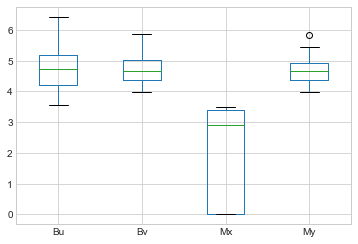

In [28]:
Knew_df.boxplot(column=['Bu', 'Bv', 'Mx', 'My'])
plt.show()

Since the ideal # of clusters for K-means is different than that of GMM, the K-means clustering technique does not exactly replicate GMM but it remains relatively similar.

In [ ]:
#Task3